In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import tensorflow as tf


import os



from glob import glob
from PIL import Image as pil_image
from matplotlib.pyplot import imshow, imsave
from IPython.display import Image as Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.utils.np_utils import to_categorical
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate, GlobalAveragePooling2D
from keras.optimizers import Adam, SGD
from keras import regularizers, initializers
from keras.layers.advanced_activations import LeakyReLU, ReLU, Softmax
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.merge import concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import *
from keras.utils import plot_model
from keras.models import load_model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.nasnet import NASNetLarge
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
#import the data 
dataframe = pd.read_csv('sample2.csv')

In [2]:
dataframe.head(9)

,Unnamed: 0,image,MEL,NV,CL,UNK
0,2,ISIC_0014927_downsampledrot90,0,1,0,0
1,5,ISIC_0015981_downsampledcntrst,0,1,0,0
2,7,ISIC_0025827cntrst,0,1,0,0
3,10,ISIC_0024380bright,0,1,0,0
4,20,ISIC_0011323rot90,0,1,0,0
5,26,ISIC_0015021_downsampledrot90,0,1,0,0
6,32,ISIC_0014787_downsampledbright,0,1,0,0
7,38,ISIC_0024478bright,0,1,0,0
8,39,ISIC_0012538_downsampledcntrst,0,1,0,0


In [3]:
df= dataframe.iloc[: , 1:]

In [4]:
df.head()

,image,MEL,NV,CL,UNK
0,ISIC_0014927_downsampledrot90,0,1,0,0
1,ISIC_0015981_downsampledcntrst,0,1,0,0
2,ISIC_0025827cntrst,0,1,0,0
3,ISIC_0024380bright,0,1,0,0
4,ISIC_0011323rot90,0,1,0,0


# Data Processing

In [5]:
df['type']=df['MEL']+1

In [6]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join('', '*', '*.jpg'))}
df['path'] = df['image'].map(image_path.get)


In [7]:
df=df.drop(columns=['NV', 'CL','UNK','MEL'])

In [8]:
image_example = np.asarray(pil_image.open(df['path'][0]))

In [9]:
df['im'] = df['path'].map(lambda x: np.asarray(pil_image.open(x).resize((120,90))))

In [10]:
df.head()

,image,type,path,im
0,ISIC_0014927_downsampledrot90,1,images_sample\ISIC_0014927_downsampledrot90.jpg,"[[[232, 220, 224], [228, 217, 219], [224, 213,..."
1,ISIC_0015981_downsampledcntrst,1,images_sample\ISIC_0015981_downsampledcntrst.jpg,"[[[152, 107, 91], [144, 108, 84], [143, 97, 68..."
2,ISIC_0025827cntrst,1,images_sample\ISIC_0025827cntrst.jpg,"[[[237, 164, 192], [240, 164, 193], [239, 158,..."
3,ISIC_0024380bright,1,images_sample\ISIC_0024380bright.jpg,"[[[247, 205, 235], [251, 209, 237], [254, 213,..."
4,ISIC_0011323rot90,1,images_sample\ISIC_0011323rot90.jpg,"[[[165, 156, 155], [166, 159, 157], [165, 161,..."


In [11]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'unk':'unknown'
   
}

lesion_classes_dict = {
    0:'unk',
    1:'nv',
    2:'mel'
    
   
}

df['cell_type'] = df['type'].map(lesion_classes_dict)

In [12]:
df

,image,type,path,im,cell_type
0,ISIC_0014927_downsampledrot90,1,images_sample\ISIC_0014927_downsampledrot90.jpg,"[[[232, 220, 224], [228, 217, 219], [224, 213,...",nv
1,ISIC_0015981_downsampledcntrst,1,images_sample\ISIC_0015981_downsampledcntrst.jpg,"[[[152, 107, 91], [144, 108, 84], [143, 97, 68...",nv
2,ISIC_0025827cntrst,1,images_sample\ISIC_0025827cntrst.jpg,"[[[237, 164, 192], [240, 164, 193], [239, 158,...",nv
3,ISIC_0024380bright,1,images_sample\ISIC_0024380bright.jpg,"[[[247, 205, 235], [251, 209, 237], [254, 213,...",nv
4,ISIC_0011323rot90,1,images_sample\ISIC_0011323rot90.jpg,"[[[165, 156, 155], [166, 159, 157], [165, 161,...",nv
...,...,...,...,...,...
1995,ISIC_0032095cntrst,2,images_sample\ISIC_0032095cntrst.jpg,"[[[176, 129, 141], [179, 132, 144], [181, 134,...",mel
1996,ISIC_0061629bright,2,images_sample\ISIC_0061629bright.jpg,"[[[104, 104, 104], [104, 104, 104], [104, 104,...",mel
1997,ISIC_0056269,2,images_sample\ISIC_0056269.jpg,"[[[192, 170, 167], [194, 170, 167], [195, 171,...",mel
1998,ISIC_0060648bright,2,images_sample\ISIC_0060648bright.jpg,"[[[219, 223, 226], [234, 235, 237], [246, 247,...",mel


## Data Splitting

In [13]:
features = df.drop(['type'],axis=1)
target = df['type']

In [14]:
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(features,target,test_size=0.01)

In [15]:
print(Y_TEST)

1540    2
411     1
523     1
1938    2
346     1
1775    2
592     1
1800    2
1352    2
669     1
844     1
841     1
282     1
1331    2
375     1
497     1
661     1
475     1
1486    2
679     1
Name: type, dtype: int64


In [16]:
x_train = np.asarray(X_TRAIN['im'].tolist())
x_test = np.asarray(X_TEST['im'].tolist())

In [17]:
train_mean = x_train.mean()
train_std = x_train.std()
test_mean = x_test.mean()
test_std = x_test.std()

## Using Image Standardization

In [18]:
x_train = (x_train-train_mean) / train_std
x_test = (x_test-test_mean) / test_std

In [19]:
y_train = to_categorical(Y_TRAIN,num_classes=3)
y_test = to_categorical(Y_TEST,num_classes=3)

In [20]:
print(y_test)

[[0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [21]:
print(y_train.shape)
print(y_test.shape)

(1980, 3)
(20, 3)


In [22]:
X_train,X_val, Y_train,Y_val = train_test_split(x_train,y_train,test_size=0.15)

In [23]:
X_train  = X_train.reshape(X_train.shape[0],90,120,3)
x_test  = x_test.reshape(x_test.shape[0],90,120,3)
X_val  = X_val.reshape(X_val.shape[0],90,120,3)

## Train Models

### 1. Simple Sequential Network


In [40]:
input_shape = (90, 120, 3)
num_classes = 3

model = Sequential()

model.add(Conv2D(32,kernel_size=(3, 3),activation='relu',name="conv1", input_shape=input_shape)) #88,118
model.add(BatchNormalization(name="Norm1"))
model.add(Conv2D(64,kernel_size=(3, 3), activation='relu',name="Conv2")) #86,116
model.add(BatchNormalization(name="Norm2"))
model.add(Conv2D(64,kernel_size=(3, 3), activation='relu',name="Conv3")) #84,114
model.add(BatchNormalization(name="Norm3"))
model.add(MaxPooling2D(pool_size = (2, 2))) # 42,57
model.add(Dropout(0.20))

model.add(Conv2D(64, (3, 3), activation='relu',name="conv4")) #40,55
model.add(BatchNormalization(name="Norm4"))
model.add(Conv2D(128, (3, 3), activation='relu',name="conv5")) #38,53
model.add(BatchNormalization(name="Norm5"))
model.add(Conv2D(128, (3, 3), activation='relu',name="conv6")) #36,51
model.add(BatchNormalization(name="Norm6"))
model.add(MaxPooling2D(pool_size=(2, 2))) #18,25
model.add(Dropout(0.20))

model.add(Conv2D(128, (3, 3), activation='relu',name="conv7")) #16,23
model.add(BatchNormalization(name="Norm7"))
model.add(Conv2D(256, (3, 3), activation='relu',name="conv8")) #14,21
model.add(BatchNormalization(name="Norm8"))
model.add(Conv2D(256, (3, 3), activation='relu',name="conv9")) #12,19
model.add(BatchNormalization(name="Norm9"))
model.add(MaxPooling2D(pool_size=(2, 2))) #6,9
model.add(Dropout(0.20))

model.add(Conv2D(3,(1,1),name="conv10",activation="relu")) #6,9
model.add(BatchNormalization(name="Norm10"))
model.add(Conv2D(3,kernel_size=(6,9),name="conv11"))
model.add(Flatten())
model.add(Activation('softmax'))

In [41]:
model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

In [28]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.0001, 
                                            min_lr=0.000001)

## Saving Checkpoint


In [24]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [25]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1 # Randomly zoom image 
)


# Fit the model
epochs = 20
batch_size = 10
model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction,cp_callback])

NameError: name 'model' is not defined

### Testing with a new image of a lesion 

Original Shape of image is :  (428, 650, 3)


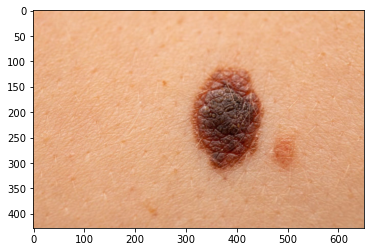

In [67]:
import urllib
url="https://2rdnmg1qbg403gumla1v9i2h-wpengine.netdna-ssl.com/wp-content/uploads/sites/3/2021/04/moleSkinCancer-1150885505-770x533-1-650x428.jpg"
urllib.request.urlretrieve(url,'test.jpg')
test_image = np.asarray(pil_image.open('test.jpg'))
print('Original Shape of image is : ',test_image.shape)
plt.imshow(test_image)

In [68]:
resized_image = np.asarray(pil_image.open('test.jpg').resize((120,90)))
image_array = np.asarray(resized_image.tolist())
test_image = image_array.reshape(1,90,120,3)

In [69]:
prediction_class = model.predict_classes(test_image)
print(prediction_class)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
[2]


In [70]:
lesion_classes_dict[prediction_class[0]]

'mel'

Original Shape of image is :  (299, 299, 3)


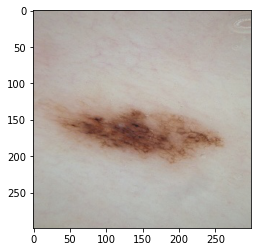

In [98]:

test_image = np.asarray(pil_image.open('images_sample\ISIC_0011323rot90.jpg'))
print('Original Shape of image is : ',test_image.shape)
plt.imshow(test_image)

In [99]:
resized_im= np.asarray(pil_image.open('test.jpg').resize((120,90)))
im_array = np.asarray(resized_im.tolist())
test_im= im_array.reshape(1,90,120,3)

In [100]:
prediction_class = model.predict_classes(test_im)
print(prediction_class)

[2]


In [101]:
lesion_classes_dict[prediction_class[0]]

'mel'

In [48]:
os.listdir(checkpoint_dir)

['checkpoint', 'cp.ckpt.data-00000-of-00001', 'cp.ckpt.index']

### 2-VGG16

In [26]:
def vgg16():
    
    height = 90
    width  = 120
    vgg = VGG16(include_top=False, input_shape=(height, width, 3))
    flat1 = Flatten()(vgg.layers[-1].output)
    class1 = Dense(1024, kernel_regularizer=regularizers.l2(0.001), activation='relu')(flat1)
    class1 = Dropout(0.5)(class1)
    output = Dense(3, activation='softmax')(class1)
    model = Model(inputs=vgg.inputs, outputs=output)

    model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [27]:
model=vgg16()

In [28]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.0001, 
                                            min_lr=0.000001)
datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1 # Randomly zoom image 
)


# Fit the model
epochs = 15
batch_size = 10
model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
168/168 [==============================] - 467s 3s/step - loss: 2.2263 - accuracy: 0.6408 - val_loss: 1.9952 - val_accuracy: 0.7744
Epoch 2/15
168/168 [==============================] - 492s 3s/step - loss: 2.0481 - accuracy: 0.7424 - val_loss: 1.9543 - val_accuracy: 0.7946
Epoch 3/15
168/168 [==============================] - 488s 3s/step - loss: 1.9792 - accuracy: 0.7753 - val_loss: 1.9690 - val_accuracy: 0.7710
Epoch 4/15
168/168 [==============================] - 439s 3s/step - loss: 1.9201 - accuracy: 0.8117 - val_loss: 1.9172 - val_accuracy: 0.7946
Epoch 5/15
168/168 [==============================] - 466s 3s/step - loss: 1.8732 - accuracy: 0.8524 - val_loss: 1.9172 - val_accuracy: 0.7980
Epoch 6/15
168/168 [==============================] - 434s 3s/step - loss: 1.8506 - accuracy: 0.8637 - val_loss: 1.9017 - val_accuracy: 0.8114
Epoch 7/15
168/168 [==============================] - 433s 3s/step

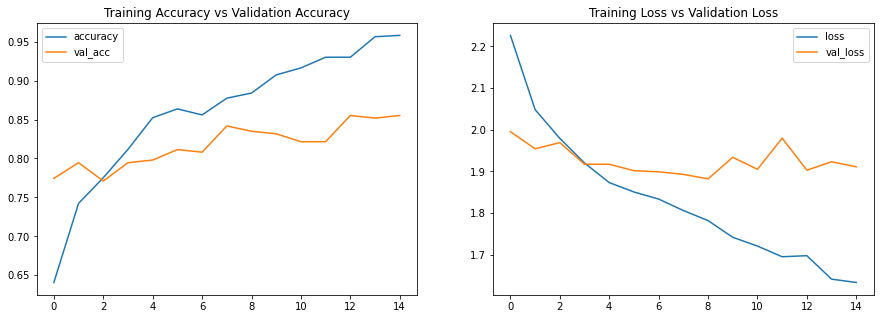

In [29]:
def plot_(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    f, [ax1, ax2] = plt.subplots(1,2, figsize=(15, 5))
    ax1.plot(range(len(acc)), acc, label="accuracy")
    ax1.plot(range(len(acc)), val_acc, label="val_acc")
    ax1.set_title("Training Accuracy vs Validation Accuracy")
    ax1.legend()

    ax2.plot(range(len(loss)), loss, label="loss")
    ax2.plot(range(len(loss)), val_loss, label="val_loss")
    ax2.set_title("Training Loss vs Validation Loss")
    ax2.legend()
    
    
plot_(model.history)

Original Shape of image is :  (194, 260, 3)


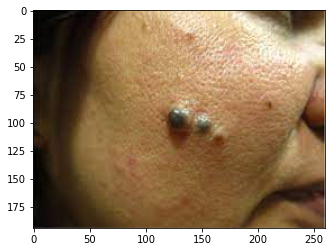

In [30]:
url="https://europepmc.org/articles/PMC3965271/bin/ccid-7-089Fig3.jpg"
test_image2 = np.asarray(pil_image.open('test2.jpg'))
print('Original Shape of image is : ',test_image2.shape)
plt.imshow(test_image2)

In [31]:
resized_image2 = np.asarray(pil_image.open('test2.jpg').resize((120,90)))
image_array2 = np.asarray(resized_image2.tolist())
test_image2 = image_array2.reshape(1,90,120,3)

In [32]:
prediction_class = model.predict(test_image2)
prediction_class = np.argmax(prediction_class,axis=1)

In [33]:
print(prediction_class)

[1]


## Inceptionv3

In [24]:
def inceptionv3():
    height = 90
    width  = 120
    
    inception = InceptionV3(include_top=False, input_shape=(height, width, 3))
    x = inception.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, kernel_regularizer=regularizers.l2(0.001), activation='relu')(x)
    x = Dropout(0.5)(x)

    predictions = Dense(3,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

    model = Model(inputs=inception.input, outputs=predictions)
    model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [25]:
model=inceptionv3()

In [37]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.0001, 
                                            min_lr=0.000001)
datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1 # Randomly zoom image 
)


# Fit the model
epochs = 15
batch_size = 10
model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/15
168/168 [==============================] - 196s 1s/step - loss: 2.2080 - accuracy: 0.5517 - val_loss: 2.1009 - val_accuracy: 0.6532
Epoch 2/15
168/168 [==============================] - 150s 891ms/step - loss: 2.0515 - accuracy: 0.6467 - val_loss: 1.9784 - val_accuracy: 0.6970
Epoch 3/15
168/168 [==============================] - 150s 894ms/step - loss: 1.9947 - accuracy: 0.6928 - val_loss: 1.9674 - val_accuracy: 0.7441
Epoch 4/15
168/168 [==============================] - 149s 889ms/step - loss: 1.9488 - accuracy: 0.7352 - val_loss: 1.9372 - val_accuracy: 0.7407
Epoch 5/15
168/168 [==============================] - 153s 909ms/step - loss: 1.9138 - accuracy: 0.7466 - val_loss: 2.1167 - val_accuracy: 0.6869
Epoch 6/15
168/168 [==============================] - 150s 894ms/step - loss: 1.9069 - accuracy: 0.7555 - val_loss: 2.0090 - val_accuracy: 0.7037
Epoch 7/15
168/168 [==============================] - 149s 885ms/step - loss: 1.8921 - accuracy: 0.7615 - val_loss: 1.9872 - va

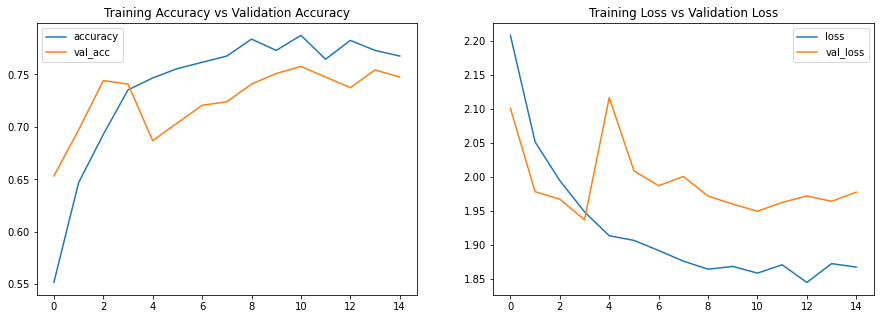

In [38]:
def plot_(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    f, [ax1, ax2] = plt.subplots(1,2, figsize=(15, 5))
    ax1.plot(range(len(acc)), acc, label="accuracy")
    ax1.plot(range(len(acc)), val_acc, label="val_acc")
    ax1.set_title("Training Accuracy vs Validation Accuracy")
    ax1.legend()

    ax2.plot(range(len(loss)), loss, label="loss")
    ax2.plot(range(len(loss)), val_loss, label="val_loss")
    ax2.set_title("Training Loss vs Validation Loss")
    ax2.legend()
    
    
plot_(model.history)

## Resnet50

In [24]:
def resnet50():
    height=90
    width=120
   
    
    resnet = ResNet50(include_top=False, input_shape=(height, width, 3))
    x = resnet.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, kernel_regularizer=regularizers.l2(0.001), activation='relu')(x)
    x = Dropout(0.5)(x)

    predictions = Dense(3,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

    model = Model(inputs=resnet.input, outputs=predictions)
    model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [25]:
model=resnet50()

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 4d473c1dd8becc155b73f8504c6f6626 so we will re-download the data.
94773248/94765736 [==============================] - 838s 9us/step


In [26]:
checkpoint_path = "training_1/cp2.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [29]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1 # Randomly zoom image 
)


# Fit the model
epochs = 15
batch_size = 10
model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction,cp_callback])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
168/168 [==============================] - ETA: 0s - loss: 2.1795 - accuracy: 0.6324
Epoch 00001: saving model to training_1\cp2.ckpt
168/168 [==============================] - 342s 2s/step - loss: 2.1795 - accuracy: 0.6324 - val_loss: 2.5513 - val_accuracy: 0.5623
Epoch 2/15
168/168 [==============================] - ETA: 0s - loss: 1.9312 - accuracy: 0.7496
Epoch 00002: saving model to training_1\cp2.ckpt
168/168 [==============================] - 412s 2s/step - loss: 1.9312 - accuracy: 0.7496 - val_loss: 2.6895 - val_accuracy: 0.5690
Epoch 3/15
168/168 [==============================] - ETA: 0s - loss: 1.8669 - accuracy: 0.7872
Epoch 00003: saving model to training_1\cp2.ckpt
168/168 [==============================] - 421s 3s/step - loss: 1.8669 - accuracy: 0.7872 - val_loss: 2.2351 - val_accuracy: 0.6094
Epoch 4/15
168/168 [==============================] - ETA: 0s - loss: 1.8471 - accuracy: 0.80

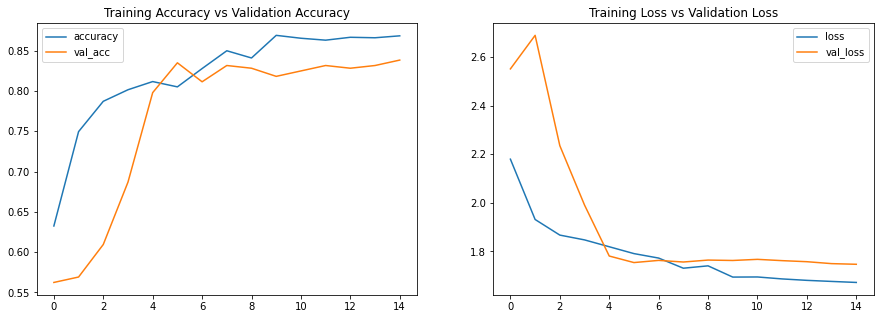

In [30]:

def plot_(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    f, [ax1, ax2] = plt.subplots(1,2, figsize=(15, 5))
    ax1.plot(range(len(acc)), acc, label="accuracy")
    ax1.plot(range(len(acc)), val_acc, label="val_acc")
    ax1.set_title("Training Accuracy vs Validation Accuracy")
    ax1.legend()

    ax2.plot(range(len(loss)), loss, label="loss")
    ax2.plot(range(len(loss)), val_loss, label="val_loss")
    ax2.set_title("Training Loss vs Validation Loss")
    ax2.legend()
    
    
plot_(model.history)

## Nasnetl

In [34]:
def nasnetL():
    height=90
    width=120
    
    nasnetl = NASNetLarge(include_top=False, input_shape=(height, width, 3))
    x = nasnetl.output
    x = GlobalAveragePooling2D()(x)
    #x = Dense(1024, kernel_regularizer=regularizers.l2(0.001), activation='relu')(x)
    #x = Dropout(0.5)(x)

    predictions = Dense(3,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

    model = Model(inputs=nasnetl.input, outputs=predictions)
    model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model
